In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive

drive.mount("/content/drive")

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = "assignment2/"
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys

sys.path.append("/content/drive/My Drive/{}".format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/assignment2/cs231n/datasets
/content/drive/My Drive/assignment2


# Batch Normalization
One way to make deep networks easier to train is to use more sophisticated optimization procedures such as SGD+momentum, RMSProp, or Adam. Another strategy is to change the architecture of the network to make it easier to train. One idea along these lines is batch normalization, proposed by [1] in 2015.

To understand the goal of batch normalization, it is important to first recognize that machine learning methods tend to perform better with input data consisting of uncorrelated features with zero mean and unit variance. When training a neural network, we can preprocess the data before feeding it to the network to explicitly decorrelate its features. This will ensure that the first layer of the network sees data that follows a nice distribution. However, even if we preprocess the input data, the activations at deeper layers of the network will likely no longer be decorrelated and will no longer have zero mean or unit variance, since they are output from earlier layers in the network. Even worse, during the training process the distribution of features at each layer of the network will shift as the weights of each layer are updated.

The authors of [1] hypothesize that the shifting distribution of features inside deep neural networks may make training deep networks more difficult. To overcome this problem, they propose to insert into the network layers that normalize batches. At training time, such a layer uses a minibatch of data to estimate the mean and standard deviation of each feature. These estimated means and standard deviations are then used to center and normalize the features of the minibatch. A running average of these means and standard deviations is kept during training, and at test time these running averages are used to center and normalize features.

It is possible that this normalization strategy could reduce the representational power of the network, since it may sometimes be optimal for certain layers to have features that are not zero-mean or unit variance. To this end, the batch normalization layer includes learnable shift and scale parameters for each feature dimension.

[1] [Sergey Ioffe and Christian Szegedy, "Batch Normalization: Accelerating Deep Network Training by Reducing
Internal Covariate Shift", ICML 2015.](https://arxiv.org/abs/1502.03167)


# バッチ正則化
ディープネットワークの学習を容易にする1つの方法は、SGD+momentum、RMSProp、またはAdamのような、より洗練された最適化手順を使用することである。もう1つの戦略は、ネットワークのアーキテクチャを変更することで学習を容易にすることである。これに沿ったアイデアの1つが、2015年に[1]によって提案されたバッチ正規化である。

バッチ正規化の目的を理解するためには、まず、機械学習手法は、平均がゼロで単位分散を持つ無相関な特徴からなる入力データでより良い性能を発揮する傾向があることを認識することが重要である。ニューラルネットワークをトレーニングする場合、ネットワークにデータを供給する前に前処理を行い、その特徴を明示的に非相関化することができる。こうすることで、ネットワークの第1層はきれいな分布に従ったデータを見ることができる。しかし、たとえ入力データを前処理したとしても、ネットワークのより深い層での活性化は、ネットワークのより早い層からの出力であるため、もはや非相関である可能性が高く、ゼロ平均や単位分散を持たない。さらに悪いことに、学習過程において、各層の重みが更新されるにつれて、ネットワークの各層における特徴の分布は変化する。

[1]の著者は、ディープ・ニューラル・ネットワーク内の特徴量の分布がずれることで、ディープ・ネットワークの学習が難しくなる可能性があるという仮説を立てている。この問題を克服するために、彼らはバッチを正規化するレイヤーをネットワークに挿入することを提案している。このようなレイヤーは、学習時にデータのミニバッチを使用して、各特徴の平均と標準偏差を推定する。これらの推定された平均と標準偏差は、ミニバッチの特徴量のセンタリングと正規化に使用される。これらの平均と標準偏差の走行平均はトレーニング中に保持され、テスト時にはこれらの走行平均が特徴の中心化と正規化に使用される。

この正規化戦略は、ネットワークの表現力を低下させる可能性がある。というのも、ゼロ平均や単位分散でない特徴量を持つことが、ある層にとって最適な場合があるからだ。このため、バッチ正規化レイヤーは、各特徴次元に対して学習可能なシフトとスケールのパラメータを含む。

In [ ]:
# Setup cell.
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # Set default size of plots.
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

%load_ext autoreload
%autoreload 2


def rel_error(x, y):
    """Returns relative error."""
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))


def print_mean_std(x, axis=0):
    print(f"  means: {x.mean(axis=axis)}")
    print(f"  stds:  {x.std(axis=axis)}\n")

In [ ]:
# 前処理済みの）CIFAR-10データをロードする。
data = get_CIFAR10_data()
for k, v in list(data.items()):
    print(f"{k}: {v.shape}")

X_train: (49000, 3, 32, 32)
y_train: (49000,)
X_val: (1000, 3, 32, 32)
y_val: (1000,)
X_test: (1000, 3, 32, 32)
y_test: (1000,)


# Batch Normalization: Forward Pass
In the file `cs231n/layers.py`, implement the batch normalization forward pass in the function `batchnorm_forward`. Once you have done so, run the following to test your implementation.

Referencing the paper linked to above in [1] may be helpful!

# バッチ正則化：Forward Pass
ファイル `cs231n/layers.py` で、関数 `batchnorm_forward` でバッチ正規化フォワードパスを実装します。実装が完了したら、実装をテストするために以下を実行してください。

上記の[1]にリンクされている論文を参照するとよいでしょう！

In [ ]:
# バッチ正規化の前と後の特徴量の平均と分散をチェックすることで
# 学習時のフォワードパスをチェックします。

# 2層ネットワークのフォワードパスをシミュレート。
np.random.seed(231)
N, D1, D2, D3 = 200, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)

print("Before batch normalization:")
print_mean_std(a, axis=0)

gamma = np.ones((D3,))
beta = np.zeros((D3,))

# 平均はゼロに近く、標準は1に近いはず。
print("After batch normalization (gamma=1, beta=0)")
a_norm, _ = batchnorm_forward(a, gamma, beta, {"mode": "train"})
print_mean_std(a_norm, axis=0)

gamma = np.asarray([1.0, 2.0, 3.0])
beta = np.asarray([11.0, 12.0, 13.0])

# 現在、平均値はベータ値に近く、標準偏差はガンマ値に近いはずだ。
print("After batch normalization (gamma=", gamma, ", beta=", beta, ")")
a_norm, _ = batchnorm_forward(a, gamma, beta, {"mode": "train"})
print_mean_std(a_norm, axis=0)

Before batch normalization:
  means: [ -2.3814598  -13.18038246   1.91780462]
  stds:  [27.18502186 34.21455511 37.68611762]

After batch normalization (gamma=1, beta=0)
  means: [5.32907052e-17 7.04991621e-17 1.85962357e-17]
  stds:  [0.99999999 1.         1.        ]

After batch normalization (gamma= [1. 2. 3.] , beta= [11. 12. 13.] )
  means: [11. 12. 13.]
  stds:  [0.99999999 1.99999999 2.99999999]



In [ ]:
# training-timeフォワードパスを何度も実行してランニングアベレージをウォームアップし、
# test-timeフォワードパスの後にアクティベーションの平均と分散をチェックすることで，
# test-timeフォワードパスをチェックする。

np.random.seed(231)
N, D1, D2, D3 = 200, 50, 60, 3
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)

bn_param = {"mode": "train"}
gamma = np.ones(D3)
beta = np.zeros(D3)

for t in range(50):
    X = np.random.randn(N, D1)
    a = np.maximum(0, X.dot(W1)).dot(W2)
    batchnorm_forward(a, gamma, beta, bn_param)

bn_param["mode"] = "test"
X = np.random.randn(N, D1)
a = np.maximum(0, X.dot(W1)).dot(W2)
a_norm, _ = batchnorm_forward(a, gamma, beta, bn_param)

# 平均値はゼロに近く、標準偏差は1に近いはずだが、
# 訓練時のフォワードパスよりもノイズが多くなるだろう。
print("After batch normalization (test-time):")
print_mean_std(a_norm, axis=0)

After batch normalization (test-time):
  means: [-0.03927354 -0.04349152 -0.10452688]
  stds:  [1.01531428 1.01238373 0.97819988]



# Batch Normalization: Backward Pass
Now implement the backward pass for batch normalization in the function `batchnorm_backward`.

To derive the backward pass you should write out the computation graph for batch normalization and backprop through each of the intermediate nodes. Some intermediates may have multiple outgoing branches; make sure to sum gradients across these branches in the backward pass.

Once you have finished, run the following to numerically check your backward pass.

In [ ]:
# バッチノルムの後方パス。
np.random.seed(231)
N, D = 4, 5
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {"mode": "train"}
fx = lambda x: batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: batchnorm_forward(x, a, beta, bn_param)[0]
fb = lambda b: batchnorm_forward(x, gamma, b, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma.copy(), dout)
db_num = eval_numerical_gradient_array(fb, beta.copy(), dout)

_, cache = batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = batchnorm_backward(dout, cache)

# 相対誤差は1e-13から1e-8の間と予想される。
print("dx error: ", rel_error(dx_num, dx))
print("dgamma error: ", rel_error(da_num, dgamma))
print("dbeta error: ", rel_error(db_num, dbeta))

dx error:  1.7029235612572515e-09
dgamma error:  7.420414216247087e-13
dbeta error:  2.8795057655839487e-12


# Batch Normalization: Alternative Backward Pass
In class we talked about two different implementations for the sigmoid backward pass. One strategy is to write out a computation graph composed of simple operations and backprop through all intermediate values. Another strategy is to work out the derivatives on paper. For example, you can derive a very simple formula for the sigmoid function's backward pass by simplifying gradients on paper.

Surprisingly, it turns out that you can do a similar simplification for the batch normalization backward pass too!  

In the forward pass, given a set of inputs $X=\begin{bmatrix}x_1\\x_2\\...\\x_N\end{bmatrix}$,

we first calculate the mean $\mu$ and variance $v$.
With $\mu$ and $v$ calculated, we can calculate the standard deviation $\sigma$  and normalized data $Y$.
The equations and graph illustration below describe the computation ($y_i$ is the i-th element of the vector $Y$).

\begin{align}
& \mu=\frac{1}{N}\sum_{k=1}^N x_k  &  v=\frac{1}{N}\sum_{k=1}^N (x_k-\mu)^2 \\
& \sigma=\sqrt{v+\epsilon}         &  y_i=\frac{x_i-\mu}{\sigma}
\end{align}

# バッチ正則化：代替Backward Pass
授業では、シグモイド・バックワード・パスの2つの異なる実装について話した。ひとつは、単純な演算からなる計算グラフを書き出し、すべての中間値をバックプロップする方法である。もう1つの方法は、紙の上で導関数を計算することである。例えば、紙の上で勾配を単純化することで、シグモイド関数のバックワードパスに関する非常に簡単な公式を導き出すことができる。

驚くべきことに、バッチ正規化の後方パスについても同様の単純化ができる.

フォワードパスでは、以下の入力セットが与えられる。

\begin{align}
X=\begin{bmatrix}x_1\\x_2\\...\\x_N\end{bmatrix},
\end{align}

まず平均$\mu$と分散$v$を計算します。
$\mu$と$v$が計算されると、標準偏差$\sigma$と正規化データ$Y$が計算できる。
下の式とグラフで計算を説明する（$y_i$はベクトル$Y$のi番目の要素）。

\begin{align}
& \mu=\frac{1}{N}\sum_{k=1}^N x_k  &  v=\frac{1}{N}\sum_{k=1}^N (x_k-\mu)^2 \\
& \sigma=\sqrt{v+\epsilon}         &  y_i=\frac{x_i-\mu}{\sigma}
\end{align}


<img src="https://raw.githubusercontent.com/cs231n/cs231n.github.io/master/assets/a2/batchnorm_graph.png">

The meat of our problem during backpropagation is to compute $\frac{\partial L}{\partial X}$, given the upstream gradient we receive, $\frac{\partial L}{\partial Y}.$ To do this, recall the chain rule in calculus gives us $\frac{\partial L}{\partial X} = \frac{\partial L}{\partial Y} \cdot \frac{\partial Y}{\partial X}$.

The unknown/hard part is $\frac{\partial Y}{\partial X}$. We can find this by first deriving step-by-step our local gradients at
$\frac{\partial v}{\partial X}$, $\frac{\partial \mu}{\partial X}$,
$\frac{\partial \sigma}{\partial v}$,
$\frac{\partial Y}{\partial \sigma}$, and $\frac{\partial Y}{\partial \mu}$,
and then use the chain rule to compose these gradients (which appear in the form of vectors!) appropriately to compute $\frac{\partial Y}{\partial X}$.

If it's challenging to directly reason about the gradients over $X$ and $Y$ which require matrix multiplication, try reasoning about the gradients in terms of individual elements $x_i$ and $y_i$ first: in that case, you will need to come up with the derivations for $\frac{\partial L}{\partial x_i}$, by relying on the Chain Rule to first calculate the intermediate $\frac{\partial \mu}{\partial x_i}, \frac{\partial v}{\partial x_i}, \frac{\partial \sigma}{\partial x_i},$ then assemble these pieces to calculate $\frac{\partial y_i}{\partial x_i}$.

You should make sure each of the intermediary gradient derivations are all as simplified as possible, for ease of implementation.

After doing so, implement the simplified batch normalization backward pass in the function `batchnorm_backward_alt` and compare the two implementations by running the following. Your two implementations should compute nearly identical results, but the alternative implementation should be a bit faster.


バックプロパゲーションで問題となるのは、$\frac{\partial L}{\partial X}$を計算することです。 これを行うには、微積分の連鎖律を思い出して、 $\frac{\partial L}{\partial X} = \frac{\partial L}{\partial Y} \cdot \frac{\partial Y}{\partial X}$ を行います。

未知で難しい部分は$\frac{\partial Y}{\partial X}$ である。まず、$\frac{\partial v}{\partial X}$, $\frac{\partial \mu}{\partial X}$,
$\frac{\partial \sigma}{\partial v}$,
$\frac{\partial Y}{\partial \sigma}$, と $\frac{\partial Y}{\partial \mu}$ の局所勾配を段階的に導出し、連鎖律を用いてこれらの勾配（ベクトルの形で現れる！）を適切に合成して、∂Y ∂X を計算することによって、これを求めることができる。

行列の掛け算を必要とする $X$ と $Y$ の勾配を直接推論するのが難しい場合は、まず個々の要素 $x_i$ と $y_i$ の観点から勾配を推論してみてください：その場合、 $\frac{\partial L}{\partial x_i}$ の導出を鎖の法則に頼って考え出し、まず中間の $\frac{\partial \mu}{\partial x_i}, \frac{\partial v}{\partial x_i}, \frac{\partial \sigma}{\partial x_i},$ を計算し、次にこれらを組み立てて $\frac{\partial y_i}{\partial x_i}$ を計算する必要があります。

各中間勾配の導出は、実装を容易にするために、すべてできるだけ単純化するようにすべきである。

その後、`batchnorm_backward_alt`関数で簡略化したバッチ正規化バックワードパスを実装し、以下を実行して2つの実装を比較してください。2つの実装はほぼ同じ結果を計算するはずですが、別の実装の方が少し速いはずです。

In [ ]:
np.random.seed(231)
N, D = 100, 500
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {"mode": "train"}
out, cache = batchnorm_forward(x, gamma, beta, bn_param)

t1 = time.time()
dx1, dgamma1, dbeta1 = batchnorm_backward(dout, cache)
t2 = time.time()
dx2, dgamma2, dbeta2 = batchnorm_backward_alt(dout, cache)
t3 = time.time()

print("dx difference: ", rel_error(dx1, dx2))
print("dgamma difference: ", rel_error(dgamma1, dgamma2))
print("dbeta difference: ", rel_error(dbeta1, dbeta2))
print("speedup: %.2fx" % ((t2 - t1) / (t3 - t2)))

dx difference:  5.344522019088175e-13
dgamma difference:  0.0
dbeta difference:  0.0
speedup: 1.82x


# Fully Connected Networks with Batch Normalization
Now that you have a working implementation for batch normalization, go back to your `FullyConnectedNet` in the file `cs231n/classifiers/fc_net.py`. Modify your implementation to add batch normalization.

Concretely, when the `normalization` flag is set to `"batchnorm"` in the constructor, you should insert a batch normalization layer before each ReLU nonlinearity. The outputs from the last layer of the network should not be normalized. Once you are done, run the following to gradient-check your implementation.

**Hint:** You might find it useful to define an additional helper layer similar to those in the file `cs231n/layer_utils.py`.

バッチ正規化の実装ができたので、`cs231n/classifiers/fc_net.py` にある `FullyConnectedNet` に戻ります。バッチ正規化を追加するために実装を修正します。

具体的には、コンストラクタの `normalization` フラグが `"batchnorm"` に設定されている場合、各 ReLU 非線形性の前にバッチ正規化レイヤーを挿入します。ネットワークの最後の層からの出力は正規化されるべきではありません。実装が終わったら、以下を実行して勾配をチェックしてください。

**ヒント:** `cs231n/layer_utils.py`にあるような追加のヘルパーレイヤーを定義すると便利です。

In [ ]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

# Wの損失は1e-4~1e-10、bの損失は1e-08~1e-10、ベータとガンマの損失は1e-08~1e-09と予想される。
for reg in [0, 3.14]:
    print("Running check with reg = ", reg)
    model = FullyConnectedNet(
        [H1, H2],
        input_dim=D,
        num_classes=C,
        reg=reg,
        weight_scale=5e-2,
        dtype=np.float64,
        normalization="batchnorm",
    )

    loss, grads = model.loss(X, y)
    print("Initial loss: ", loss)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print("%s relative error: %.2e" % (name, rel_error(grad_num, grads[name])))
    if reg == 0:
        print()

Running check with reg =  0
Initial loss:  2.2611955101340957
W1 relative error: 1.10e-04
W2 relative error: 5.65e-06
W3 relative error: 4.14e-10
b1 relative error: 2.66e-07
b2 relative error: 2.22e-08
b3 relative error: 1.02e-10
beta1 relative error: 7.33e-09
beta2 relative error: 1.17e-09
gamma1 relative error: 7.47e-09
gamma2 relative error: 3.35e-09

Running check with reg =  3.14
Initial loss:  6.996533220108303
W1 relative error: 1.98e-06
W2 relative error: 2.29e-06
W3 relative error: 2.79e-08
b1 relative error: 1.67e-08
b2 relative error: 7.99e-07
b3 relative error: 2.10e-10
beta1 relative error: 6.32e-09
beta2 relative error: 3.48e-09
gamma1 relative error: 6.27e-09
gamma2 relative error: 4.14e-09


# Batch Normalization for Deep Networks
Run the following to train a six-layer network on a subset of 1000 training examples both with and without batch normalization.

バッチ正規化の有無にかかわらず、1000個の訓練例のサブセットで6層ネットワークを訓練するために、以下を実行する。

In [ ]:
np.random.seed(231)

# バッチノルムでDeep Networkをトレーニングしてみよう。
hidden_dims = [100, 100, 100, 100, 100]

num_train = 1000
small_data = {
    "X_train": data["X_train"][:num_train],
    "y_train": data["y_train"][:num_train],
    "X_val": data["X_val"],
    "y_val": data["y_val"],
}

weight_scale = 2e-2
bn_model = FullyConnectedNet(
    hidden_dims, weight_scale=weight_scale, normalization="batchnorm"
)
model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization=None)

print("Solver with batch norm:")
bn_solver = Solver(
    bn_model,
    small_data,
    num_epochs=10,
    batch_size=50,
    update_rule="adam",
    optim_config={
        "learning_rate": 1e-3,
    },
    verbose=True,
    print_every=20,
)
bn_solver.train()

print("\nSolver without batch norm:")
solver = Solver(
    model,
    small_data,
    num_epochs=10,
    batch_size=50,
    update_rule="adam",
    optim_config={
        "learning_rate": 1e-3,
    },
    verbose=True,
    print_every=20,
)
solver.train()

Solver with batch norm:
(Iteration 1 / 200) loss: 2.340974
(Epoch 0 / 10) train acc: 0.107000; val_acc: 0.115000
(Epoch 1 / 10) train acc: 0.315000; val_acc: 0.266000
(Iteration 21 / 200) loss: 2.039365
(Epoch 2 / 10) train acc: 0.385000; val_acc: 0.279000
(Iteration 41 / 200) loss: 2.041103
(Epoch 3 / 10) train acc: 0.492000; val_acc: 0.308000
(Iteration 61 / 200) loss: 1.753903
(Epoch 4 / 10) train acc: 0.533000; val_acc: 0.308000
(Iteration 81 / 200) loss: 1.246585
(Epoch 5 / 10) train acc: 0.575000; val_acc: 0.313000
(Iteration 101 / 200) loss: 1.320591
(Epoch 6 / 10) train acc: 0.637000; val_acc: 0.338000
(Iteration 121 / 200) loss: 1.157329
(Epoch 7 / 10) train acc: 0.689000; val_acc: 0.324000
(Iteration 141 / 200) loss: 1.145713
(Epoch 8 / 10) train acc: 0.768000; val_acc: 0.324000
(Iteration 161 / 200) loss: 0.689452
(Epoch 9 / 10) train acc: 0.784000; val_acc: 0.328000
(Iteration 181 / 200) loss: 0.949979
(Epoch 10 / 10) train acc: 0.780000; val_acc: 0.317000

Solver without b

Run the following to visualize the results from two networks trained above. You should find that using batch normalization helps the network to converge much faster.

上記で学習した2つのネットワークの結果を可視化するために、以下を実行する。バッチ正規化を使うことで、ネットワークがより早く収束することがわかるはずだ。

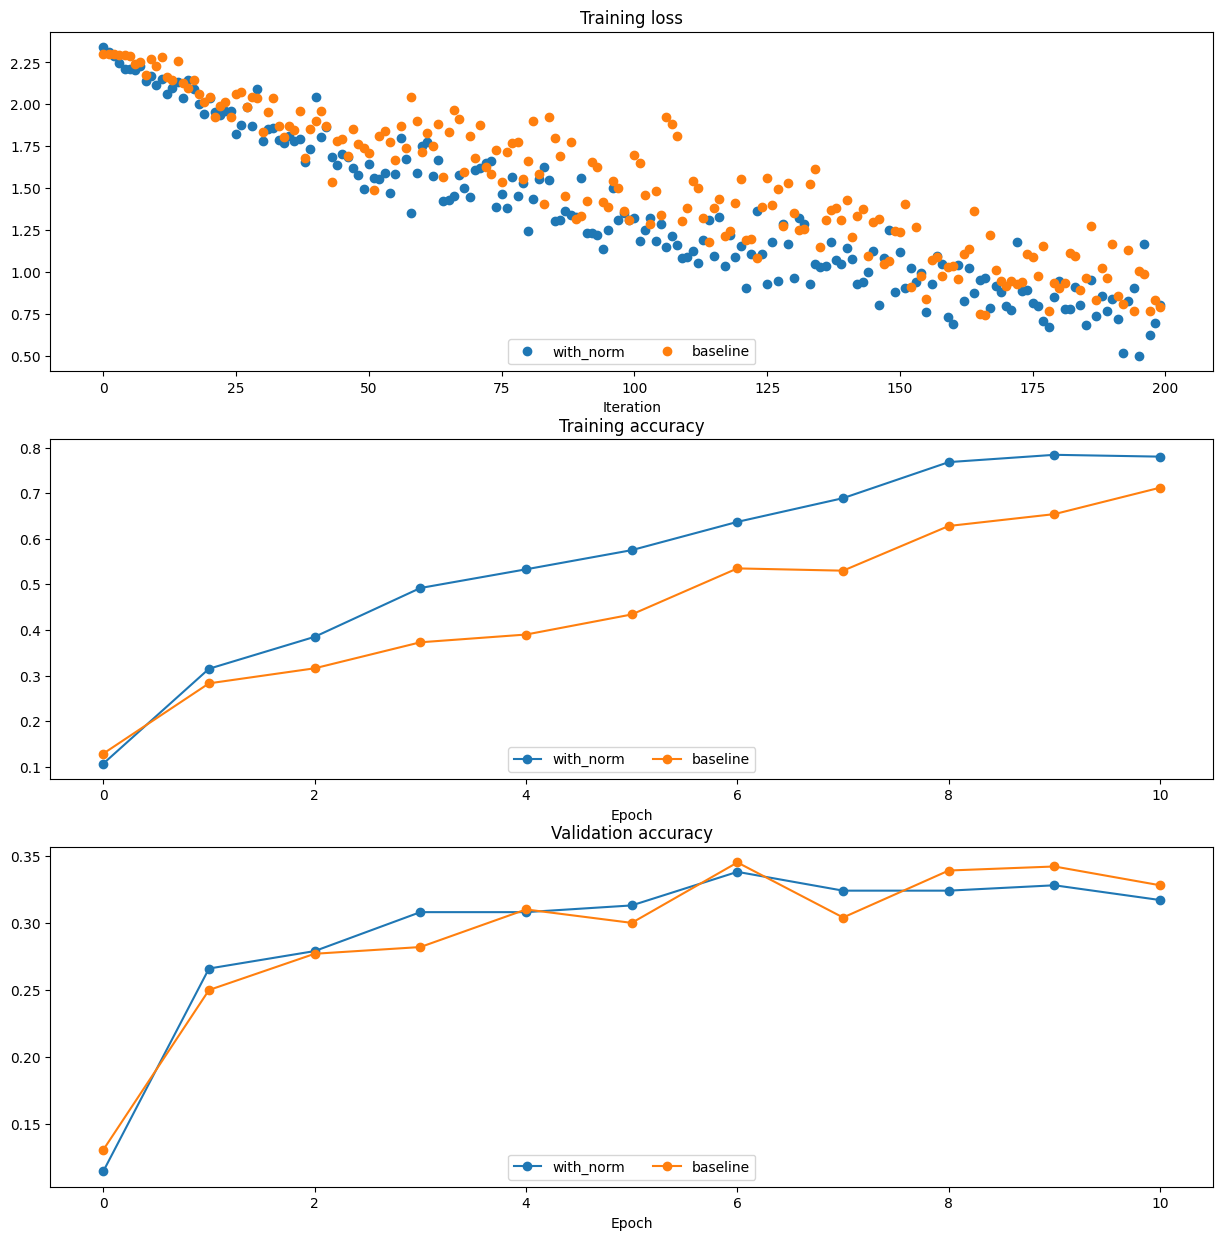

In [ ]:
def plot_training_history(
    title,
    label,
    baseline,
    bn_solvers,
    plot_fn,
    bl_marker=".",
    bn_marker=".",
    labels=None,
):
    """utility function for plotting training history"""
    plt.title(title)
    plt.xlabel(label)
    bn_plots = [plot_fn(bn_solver) for bn_solver in bn_solvers]
    bl_plot = plot_fn(baseline)
    num_bn = len(bn_plots)
    for i in range(num_bn):
        label = "with_norm"
        if labels is not None:
            label += str(labels[i])
        plt.plot(bn_plots[i], bn_marker, label=label)
    label = "baseline"
    if labels is not None:
        label += str(labels[0])
    plt.plot(bl_plot, bl_marker, label=label)
    plt.legend(loc="lower center", ncol=num_bn + 1)


plt.subplot(3, 1, 1)
plot_training_history(
    "Training loss",  # トレーニング　損失
    "Iteration",
    solver,
    [bn_solver],
    lambda x: x.loss_history,
    bl_marker="o",
    bn_marker="o",
)
plt.subplot(3, 1, 2)
plot_training_history(
    "Training accuracy",  # トレーニングデータの精度
    "Epoch",
    solver,
    [bn_solver],
    lambda x: x.train_acc_history,
    bl_marker="-o",
    bn_marker="-o",
)
plt.subplot(3, 1, 3)
plot_training_history(
    "Validation accuracy",  # 検証データの精度
    "Epoch",
    solver,
    [bn_solver],
    lambda x: x.val_acc_history,
    bl_marker="-o",
    bn_marker="-o",
)

plt.gcf().set_size_inches(15, 15)
plt.show()

# Batch Normalization and Initialization
We will now run a small experiment to study the interaction of batch normalization and weight initialization.

The first cell will train eight-layer networks both with and without batch normalization using different scales for weight initialization. The second layer will plot training accuracy, validation set accuracy, and training loss as a function of the weight initialization scale.

ここで、バッチ正規化とウェイト初期化の相互作用を調べるために、小さな実験を行う。

最初のセルでは、重みの初期化のスケールを変えて、バッチ正規化ありとなしの両方で8層ネットワークを訓練する。第2層は、トレーニング精度、検証セット精度、トレーニング損失を、重み初期化のスケールの関数としてプロットする。

In [ ]:
np.random.seed(231)

# Try training a very deep net with batchnorm.
hidden_dims = [50, 50, 50, 50, 50, 50, 50]
num_train = 1000
small_data = {
    "X_train": data["X_train"][:num_train],
    "y_train": data["y_train"][:num_train],
    "X_val": data["X_val"],
    "y_val": data["y_val"],
}

bn_solvers_ws = {}
solvers_ws = {}
weight_scales = np.logspace(-4, 0, num=20)
for i, weight_scale in enumerate(weight_scales):
    print("Running weight scale %d / %d" % (i + 1, len(weight_scales)))
    bn_model = FullyConnectedNet(
        hidden_dims, weight_scale=weight_scale, normalization="batchnorm"
    )
    model = FullyConnectedNet(
        hidden_dims, weight_scale=weight_scale, normalization=None
    )

    bn_solver = Solver(
        bn_model,
        small_data,
        num_epochs=10,
        batch_size=50,
        update_rule="adam",
        optim_config={
            "learning_rate": 1e-3,
        },
        verbose=False,
        print_every=200,
    )
    bn_solver.train()
    bn_solvers_ws[weight_scale] = bn_solver

    solver = Solver(
        model,
        small_data,
        num_epochs=10,
        batch_size=50,
        update_rule="adam",
        optim_config={
            "learning_rate": 1e-3,
        },
        verbose=False,
        print_every=200,
    )
    solver.train()
    solvers_ws[weight_scale] = solver

Running weight scale 1 / 20
Running weight scale 2 / 20
Running weight scale 3 / 20
Running weight scale 4 / 20
Running weight scale 5 / 20
Running weight scale 6 / 20
Running weight scale 7 / 20
Running weight scale 8 / 20
Running weight scale 9 / 20
Running weight scale 10 / 20
Running weight scale 11 / 20
Running weight scale 12 / 20
Running weight scale 13 / 20
Running weight scale 14 / 20
Running weight scale 15 / 20
Running weight scale 16 / 20
Running weight scale 17 / 20
Running weight scale 18 / 20
Running weight scale 19 / 20
Running weight scale 20 / 20


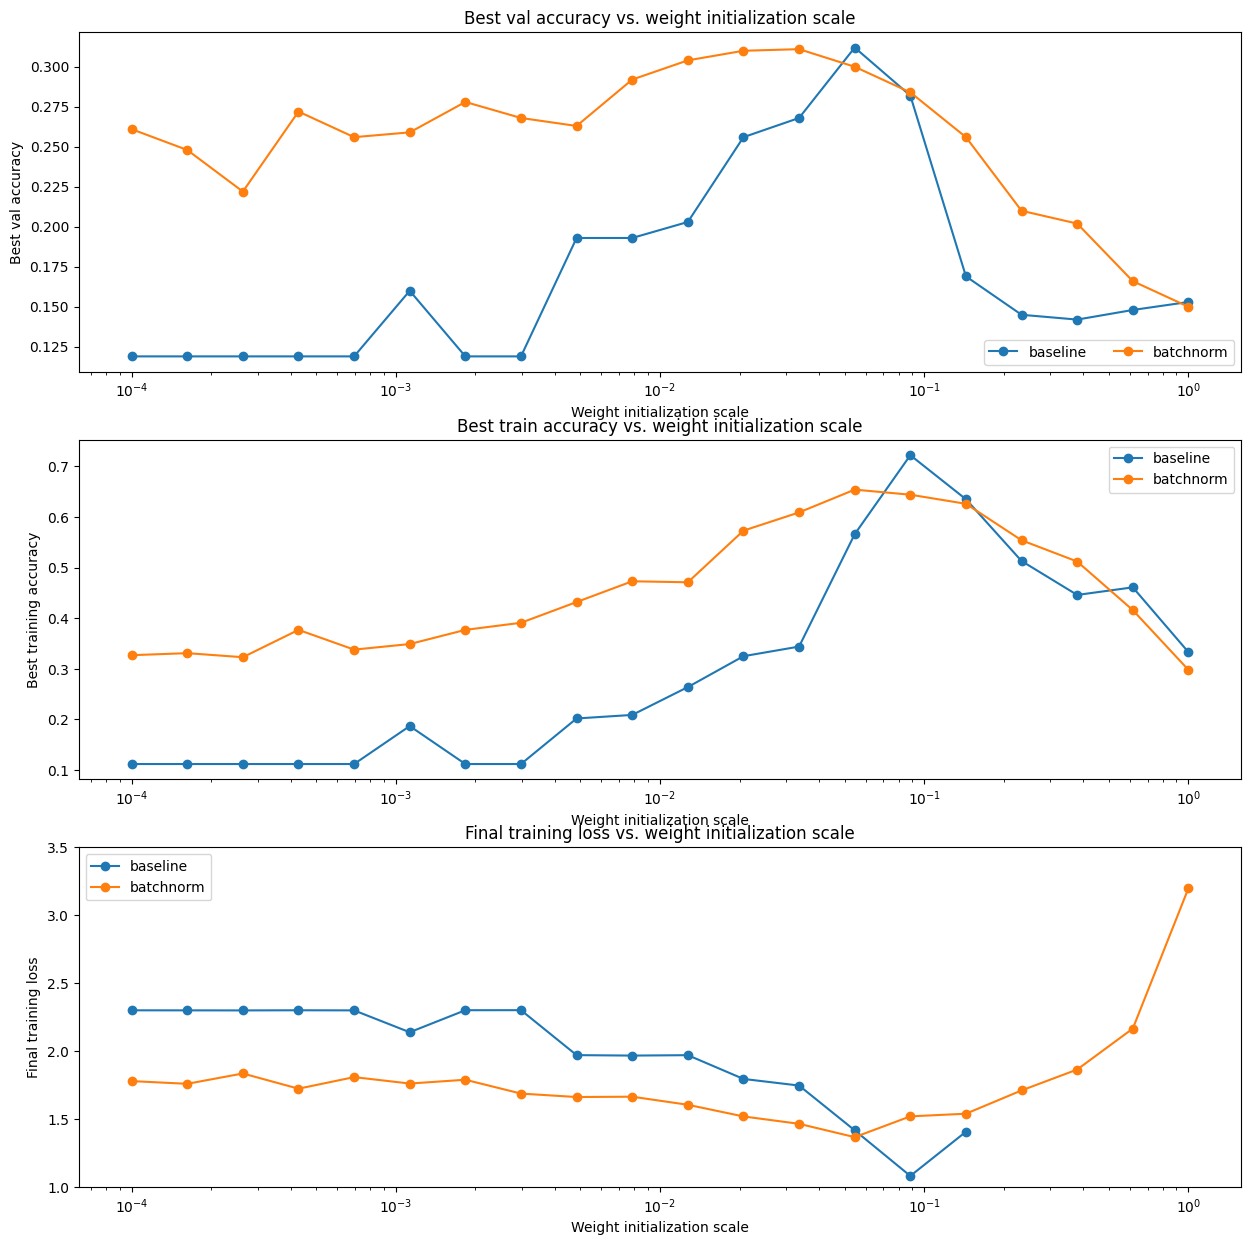

In [ ]:
# 重さの実験結果をプロット
best_train_accs, bn_best_train_accs = [], []
best_val_accs, bn_best_val_accs = [], []
final_train_loss, bn_final_train_loss = [], []

for ws in weight_scales:
    best_train_accs.append(max(solvers_ws[ws].train_acc_history))
    bn_best_train_accs.append(max(bn_solvers_ws[ws].train_acc_history))

    best_val_accs.append(max(solvers_ws[ws].val_acc_history))
    bn_best_val_accs.append(max(bn_solvers_ws[ws].val_acc_history))

    final_train_loss.append(np.mean(solvers_ws[ws].loss_history[-100:]))
    bn_final_train_loss.append(np.mean(bn_solvers_ws[ws].loss_history[-100:]))

plt.subplot(3, 1, 1)
plt.title("Best val accuracy vs. weight initialization scale")
plt.xlabel("Weight initialization scale")
plt.ylabel("Best val accuracy")  # 検証用データの精度
plt.semilogx(weight_scales, best_val_accs, "-o", label="baseline")
plt.semilogx(weight_scales, bn_best_val_accs, "-o", label="batchnorm")
plt.legend(ncol=2, loc="lower right")

plt.subplot(3, 1, 2)
plt.title("Best train accuracy vs. weight initialization scale")
plt.xlabel("Weight initialization scale")
plt.ylabel("Best training accuracy")  # トレーニングデータの精度
plt.semilogx(weight_scales, best_train_accs, "-o", label="baseline")
plt.semilogx(weight_scales, bn_best_train_accs, "-o", label="batchnorm")
plt.legend()

plt.subplot(3, 1, 3)
plt.title("Final training loss vs. weight initialization scale")
plt.xlabel("Weight initialization scale")
plt.ylabel("Final training loss")  # トレーニングデータの損失
plt.semilogx(weight_scales, final_train_loss, "-o", label="baseline")
plt.semilogx(weight_scales, bn_final_train_loss, "-o", label="batchnorm")
plt.legend()
plt.gca().set_ylim(1.0, 3.5)

plt.gcf().set_size_inches(15, 15)
plt.show()

## Inline Question 1:
この実験の結果を説明してください。ウェイトの初期化スケールは、バッチ正規化の有無によってモデルにどのような影響を与えますか？

## Answer:

1. **全体的な精度**
  * 全体として、バッチ正規化の方が精度と損失が良い。Weight initializationの値が$10^{-1}$で_batchnorm_を使わない方が学習精度が良いというスパイクがありますが、検証精度は_batchnorm_を使った場合と同じです。
  * 勾配降下ステップがより損失最小に向かうので、_batchnorm_がより良い結果を出すのは合理的です。ネットワークのパラメータは各入力に関連付けられ、そのスケールが異なると、特定のパラメータ勾配をより重視する厄介な損失関数トポロジーになる可能性がある。そのため、正規化_を使用せずに、より高い損失が求められるのです。
2. **ロバスト性**。
  * また、_batch normalization_は、異なるウェイトスケールの初期化に対して、よりスムーズな結果をもたらすことも注目すべき点です。これがないと、初期化を少し変えただけで、顕著に異なる結果が出る可能性があります。
  * バッチ正規化_では、中心化されたデータの分離が容易になるため、より良い滑らかさが保証されます。言い換えれば、重みの小さな変更は、非中心化データの重みを変更するのに比べて、それほど大きな出力の違いを引き起こさない。

3. **安定性**
  * 最後に、_batch normalization_は、重みを非常に大きく、あるいは非常に小さく初期化しても、正確な結果が得られます。$10^0のような大きなウェイトや、10^{-4}$のような小さなウェイトでは、_baseline_が適切な勾配降下を行うことができず、精度に歪みが生じます。
  * これは、複数の層で正規化を行わないと、重みの初期化が大きいと出力値が大きくなり、初期化が小さいと出力値が小さくなるためです。大きな誤差勾配が蓄積されると、重みの更新が大きくなり、勾配が_expode_することになり、低い誤差勾配が蓄積されると、重みの更新が小さくなり、勾配が_vanish_することになります。各レイヤーの生出力の後にバッチを正規化することで、各データの平均値がバッチの平均値から`1`だけ広がるようなスケールにデータを戻すことができる。


# Batch Normalization and Batch Size
We will now run a small experiment to study the interaction of batch normalization and batch size.

The first cell will train 6-layer networks both with and without batch normalization using different batch sizes. The second layer will plot training accuracy and validation set accuracy over time.

ここで、バッチ正規化とバッチサイズの相互作用を調べるために、小さな実験を行う。

最初のセルでは、異なるバッチサイズを用いて、バッチ正規化の有無に関わらず6層のネットワークを訓練する。2番目のレイヤーは、トレーニングの精度と検証セットの精度を経時的にプロットする。

In [ ]:
def run_batchsize_experiments(normalization_mode):
    np.random.seed(231)

    # Try training a very deep net with batchnorm.
    hidden_dims = [100, 100, 100, 100, 100]
    num_train = 1000
    small_data = {
        "X_train": data["X_train"][:num_train],
        "y_train": data["y_train"][:num_train],
        "X_val": data["X_val"],
        "y_val": data["y_val"],
    }
    n_epochs = 10
    weight_scale = 2e-2
    batch_sizes = [5, 10, 50]  # バッチサイズを5,10,50に設定
    lr = 10 ** (-3.5)
    solver_bsize = batch_sizes[0]

    print("No normalization: batch size = ", solver_bsize)
    model = FullyConnectedNet(
        hidden_dims, weight_scale=weight_scale, normalization=None
    )
    solver = Solver(
        model,
        small_data,
        num_epochs=n_epochs,
        batch_size=solver_bsize,
        update_rule="adam",
        optim_config={
            "learning_rate": lr,
        },
        verbose=False,
    )
    solver.train()

    bn_solvers = []
    for i in range(len(batch_sizes)):
        b_size = batch_sizes[i]
        print("Normalization: batch size = ", b_size)
        bn_model = FullyConnectedNet(
            hidden_dims, weight_scale=weight_scale, normalization=normalization_mode
        )
        bn_solver = Solver(
            bn_model,
            small_data,
            num_epochs=n_epochs,
            batch_size=b_size,
            update_rule="adam",
            optim_config={
                "learning_rate": lr,
            },
            verbose=False,
        )
        bn_solver.train()
        bn_solvers.append(bn_solver)

    return bn_solvers, solver, batch_sizes


batch_sizes = [5, 10, 50]
bn_solvers_bsize, solver_bsize, batch_sizes = run_batchsize_experiments("batchnorm")

No normalization: batch size =  5
Normalization: batch size =  5
Normalization: batch size =  10
Normalization: batch size =  50


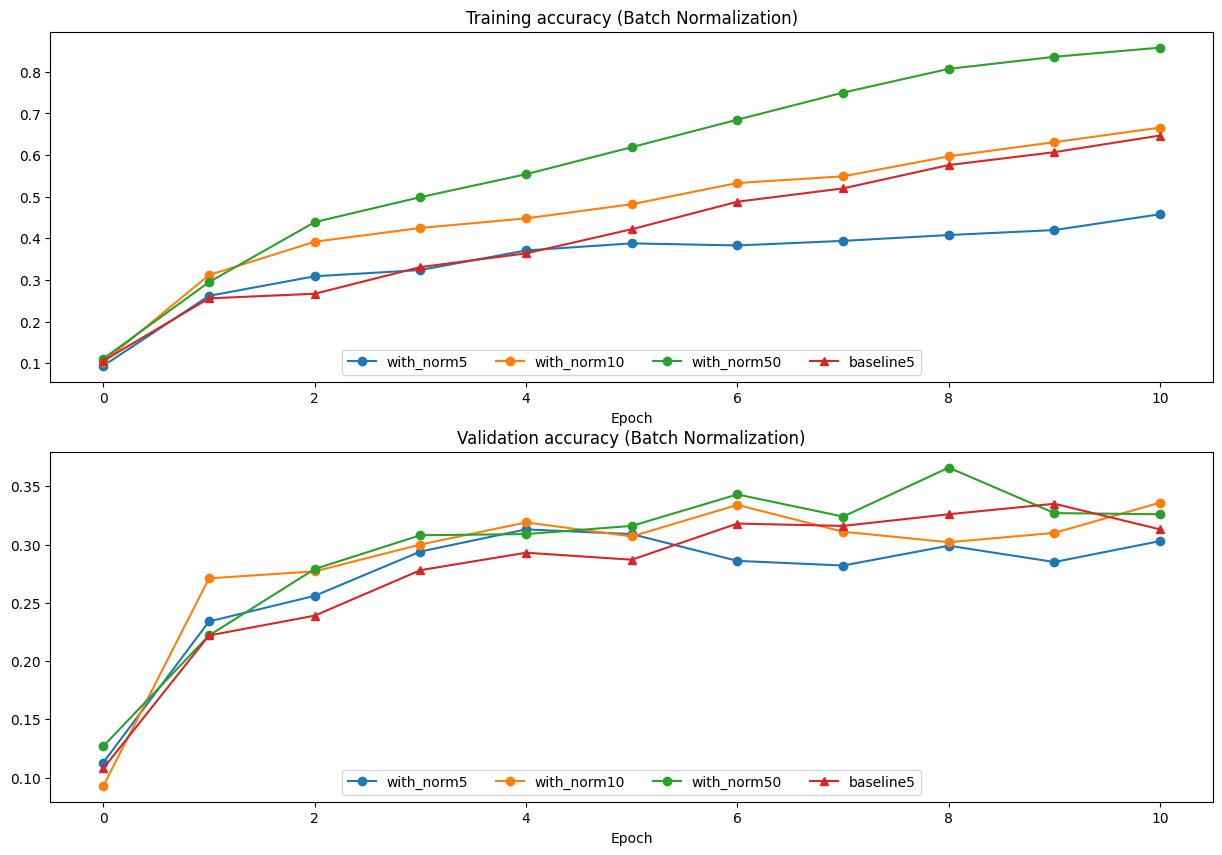

In [ ]:
plt.subplot(2, 1, 1)
plot_training_history(
    "Training accuracy (Batch Normalization)",
    "Epoch",
    solver_bsize,
    bn_solvers_bsize,
    lambda x: x.train_acc_history,
    bl_marker="-^",
    bn_marker="-o",
    labels=batch_sizes,
)
plt.subplot(2, 1, 2)
plot_training_history(
    "Validation accuracy (Batch Normalization)",
    "Epoch",
    solver_bsize,
    bn_solvers_bsize,
    lambda x: x.val_acc_history,
    bl_marker="-^",
    bn_marker="-o",
    labels=batch_sizes,
)

plt.gcf().set_size_inches(15, 10)
plt.show()

## Inline Question 2:
この実験の結果を説明してください。この結果は、バッチの正規化とバッチ・サイズの関係について何を示唆していますか？なぜこのような関係が観察されるのですか？

## Answer:
1. **訓練精度**
  * バッチサイズを大きくすると学習精度が向上することがわかる。baseline_と比較すると、同じバッチサイズ（つまり`5`）であれば、_batchnorm_を使わなくてもより良いトレーニング精度が得られます。
  * バッチサイズによってトレーニングの精度が向上するのは合理的です。モデルがより多くの訓練例を見れば見るほど、その明示的な特徴に適応するように訓練され（オーバーフィットし）、分類が容易になります。バッチサイズが小さい場合（例：`5`）、モデルは調整された特徴量よりも生の（厳密な）特徴量を基に学習するため、_batchnorm_がない方が良い結果が得られる可能性が高い。バッチサイズが小さいと、_mean_と_variance_を近似しようとするため、調整された特徴量はノイズが多くなります。

2. **検証精度**
  * 2つ目のプロットは同様の傾向（バッチが大きいほど精度が高い）を示している一方で、バッチ・サイズへの依存度は低く、十分な数のエポックがあればほぼ同様の結果が得られることが分かります。
  * バッチサイズが大きいほど、モデルは数エポック以内に速く収束するので、より良い精度が得られますが、モデルは最終的にすべてのバッチサイズで収束するので、性能は一定量のエポック後に等しくなります。トレーニング精度と比較すると、モデルはトレーニングセットほど検証セットをオーバーフィットさせることができないため、時間を通しての性能はバッチサイズにあまり依存しません。

# Layer Normalization
Batch normalization has proved to be effective in making networks easier to train, but the dependency on batch size makes it less useful in complex networks which have a cap on the input batch size due to hardware limitations.

Several alternatives to batch normalization have been proposed to mitigate this problem; one such technique is Layer Normalization [2]. Instead of normalizing over the batch, we normalize over the features. In other words, when using Layer Normalization, each feature vector corresponding to a single datapoint is normalized based on the sum of all terms within that feature vector.

[2] [Ba, Jimmy Lei, Jamie Ryan Kiros, and Geoffrey E. Hinton. "Layer Normalization." stat 1050 (2016): 21.](https://arxiv.org/pdf/1607.06450.pdf)

バッチ正規化はネットワークの学習を容易にするのに有効であることが証明されていますが、バッチサイズに依存するため、ハードウェアの制限により入力バッチサイズに上限がある複雑なネットワークではあまり役に立ちません。

この問題を軽減するために、バッチ正規化に代わる手法がいくつか提案されている。バッチを正規化する代わりに、特徴を正規化する。言い換えると、レイヤー正規化を使用する場合、1つのデータポイントに対応する各特徴ベクトルは、その特徴ベクトル内のすべての項の合計に基づいて正規化されます。


## Inline Question 3:
これらのデータ前処理ステップのうち、バッチ正規化と類似しているのはどれか、レイヤー正規化と類似しているのはどれか。

1. データセットの各画像をスケーリングし、画像内の各ピクセル行のRGBチャンネルの合計が1になるようにする。
2. データセットの各画像をスケーリングして、画像内のすべてのピクセルのRGBチャンネルの合計が1になるようにする。
3. データセットの各画像からデータセットの平均画像を引く。
4. 与えられた閾値によって、すべてのRGB値を0か1のいずれかに設定する。

## Answer:

**バッチ正規化** - 複数の特徴ベクトルが与えられた場合、各特徴は複数のサンプルにわたって同じ特徴（同じインデックス）に基づいて正規化される。

**レイヤー正規化** - 1つの特徴ベクトルが与えられた場合、各特徴は、唯一のサンプルにわたって、他の特徴（異なるインデックス）に基づいて正規化される。

Questionの回答：
* `2` は**レイヤー正規化**に類似している。なぜなら、ピクセルの単一のベクトルが与えられたとき、同じベクトル内の他のすべてのピクセルに対して各ピクセルをスケーリングするからである。
* `3`は**バッチ正規化**に似ている。なぜなら、複数の画像が与えられた場合、各画像を他のすべての画像（の平均）に対してシフトさせるからである。


# Layer Normalization: Implementation

Now you'll implement layer normalization. This step should be relatively straightforward, as conceptually the implementation is almost identical to that of batch normalization. One significant difference though is that for layer normalization, we do not keep track of the moving moments, and the testing phase is identical to the training phase, where the mean and variance are directly calculated per datapoint.

Here's what you need to do:

* In `cs231n/layers.py`, implement the forward pass for layer normalization in the function `layernorm_forward`.

Run the cell below to check your results.
* In `cs231n/layers.py`, implement the backward pass for layer normalization in the function `layernorm_backward`.

Run the second cell below to check your results.
* Modify `cs231n/classifiers/fc_net.py` to add layer normalization to the `FullyConnectedNet`. When the `normalization` flag is set to `"layernorm"` in the constructor, you should insert a layer normalization layer before each ReLU nonlinearity.

Run the third cell below to run the batch size experiment on layer normalization.

次に、レイヤーの正規化を実装する。概念的にはバッチ正規化とほとんど同じなので、このステップは比較的簡単でしょう。しかし、1つの大きな違いは、レイヤー正規化では移動モーメントを追跡せず、テストフェーズはトレーニングフェーズと同じで、データポイントごとに平均と分散を直接計算することです。

以下はその例である：

* `cs231n/layers.py`の関数 `layernorm_forward` で、レイヤーの正規化のためのフォワードパスを実装します。

以下のセルを実行して結果を確認します。
* `cs231n/layers.py` で、関数 `layernorm_backward` を用いてレイヤーの正規化のためのバックワードパスを実装します。

以下の2番目のセルを実行して結果を確認します。
* `cs231n/classifiers/fc_net.py`を修正して、`FullyConnectedNet`にレイヤーの正規化を追加する。コンストラクタの `normalization` フラグが `"layernorm"` に設定されている場合、各 ReLU 非線形性の前にレイヤーの正規化レイヤーを挿入します。

以下の3番目のセルを実行して、レイヤーの正規化に関するバッチサイズの実験を実行する。

In [ ]:
# Check the training-time forward pass by checking means and variances
# of features both before and after layer normalization.

# Simulate the forward pass for a two-layer network.
np.random.seed(231)
N, D1, D2, D3 = 4, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)

print("Before layer normalization:")
print_mean_std(a, axis=1)

gamma = np.ones(D3)
beta = np.zeros(D3)

# Means should be close to zero and stds close to one.
print("After layer normalization (gamma=1, beta=0)")
a_norm, _ = layernorm_forward(a, gamma, beta, {"mode": "train"})
print_mean_std(a_norm, axis=1)

gamma = np.asarray([3.0, 3.0, 3.0])
beta = np.asarray([5.0, 5.0, 5.0])

# Now means should be close to beta and stds close to gamma.
print("After layer normalization (gamma=", gamma, ", beta=", beta, ")")
a_norm, _ = layernorm_forward(a, gamma, beta, {"mode": "train"})
print_mean_std(a_norm, axis=1)

Before layer normalization:
  means: [-59.06673243 -47.60782686 -43.31137368 -26.40991744]
  stds:  [10.07429373 28.39478981 35.28360729  4.01831507]

After layer normalization (gamma=1, beta=0)
  means: [ 4.81096644e-16 -7.40148683e-17  2.22044605e-16 -5.92118946e-16]
  stds:  [0.99999995 0.99999999 1.         0.99999969]

After layer normalization (gamma= [3. 3. 3.] , beta= [5. 5. 5.] )
  means: [5. 5. 5. 5.]
  stds:  [2.99999985 2.99999998 2.99999999 2.99999907]



In [ ]:
# Gradient check batchnorm backward pass.
np.random.seed(231)
N, D = 4, 5
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

ln_param = {}
fx = lambda x: layernorm_forward(x, gamma, beta, ln_param)[0]
fg = lambda a: layernorm_forward(x, a, beta, ln_param)[0]
fb = lambda b: layernorm_forward(x, gamma, b, ln_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma.copy(), dout)
db_num = eval_numerical_gradient_array(fb, beta.copy(), dout)

_, cache = layernorm_forward(x, gamma, beta, ln_param)
dx, dgamma, dbeta = layernorm_backward(dout, cache)

# You should expect to see relative errors between 1e-12 and 1e-8.
print("dx error: ", rel_error(dx_num, dx))
print("dgamma error: ", rel_error(da_num, dgamma))
print("dbeta error: ", rel_error(db_num, dbeta))

dx error:  1.433616168873336e-09
dgamma error:  4.519489546032799e-12
dbeta error:  2.276445013433725e-12


# Layer Normalization and Batch Size

We will now run the previous batch size experiment with layer normalization instead of batch normalization. Compared to the previous experiment, you should see a markedly smaller influence of batch size on the training history!

ここで、バッチ正規化の代わりにレイヤー正規化を用いて、前回のバッチサイズ実験を実行する。前回の実験と比べると、バッチサイズが学習履歴に与える影響が明らかに小さくなっているのがわかるはずだ！

No normalization: batch size =  5
Normalization: batch size =  5
Normalization: batch size =  10
Normalization: batch size =  50


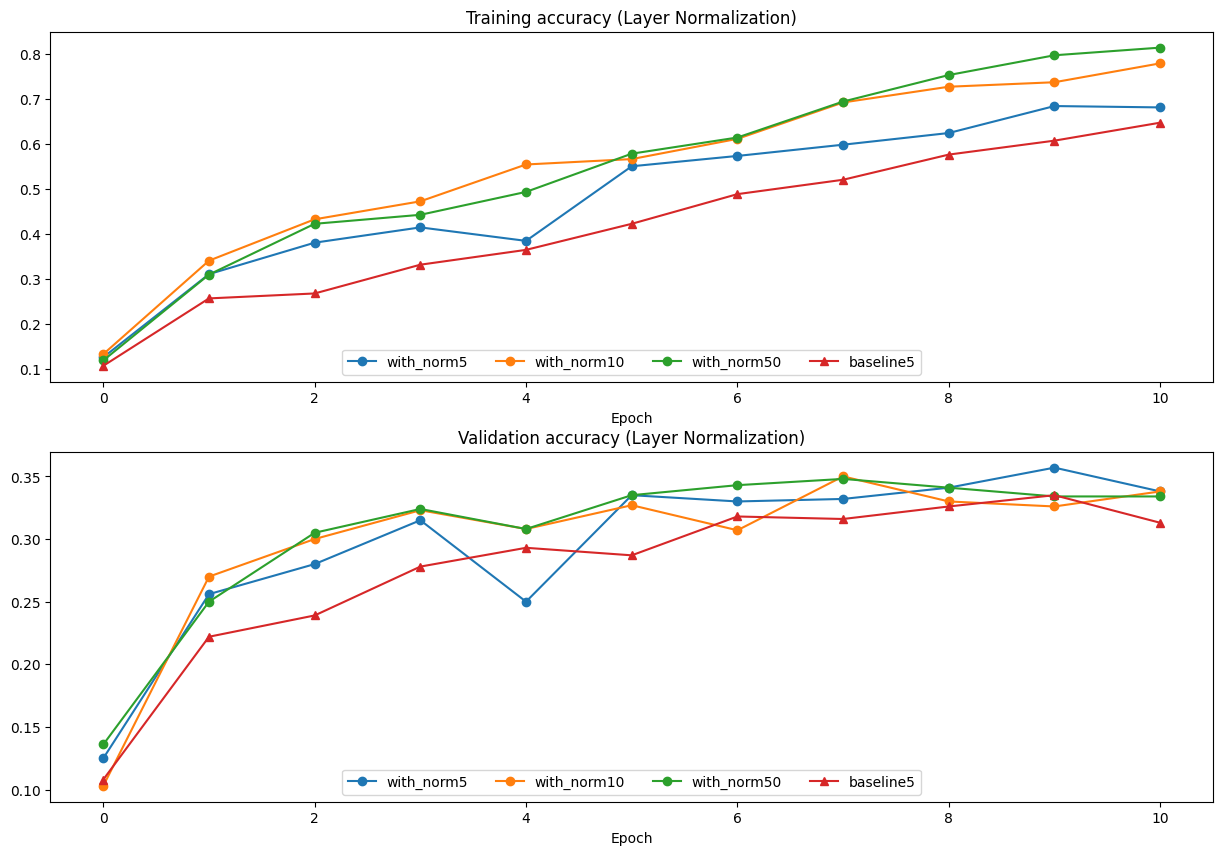

In [ ]:
ln_solvers_bsize, solver_bsize, batch_sizes = run_batchsize_experiments("layernorm")

plt.subplot(2, 1, 1)
plot_training_history(
    "Training accuracy (Layer Normalization)",
    "Epoch",
    solver_bsize,
    ln_solvers_bsize,
    lambda x: x.train_acc_history,
    bl_marker="-^",
    bn_marker="-o",
    labels=batch_sizes,
)
plt.subplot(2, 1, 2)
plot_training_history(
    "Validation accuracy (Layer Normalization)",
    "Epoch",
    solver_bsize,
    ln_solvers_bsize,
    lambda x: x.val_acc_history,
    bl_marker="-^",
    bn_marker="-o",
    labels=batch_sizes,
)

plt.gcf().set_size_inches(15, 10)
plt.show()

## Inline Question 4:
レイヤー正規化がうまくいかないのはどのような場合か？

1. 非常に深いネットワークでの使用
2. 特徴の次元が非常に小さい
3. 高い正則化項を持つ


## Answer:
1. **False** - データの特徴ベクトルはレイヤーごとに正規化されるため、レイヤーを追加してもレイヤー正規化のパフォーマンスは低下しない。各特徴ベクトルを正規化することで、損失関数のトポロジーが歪むことが少なくなり、各特徴ベクトルがその空間内でほぼ中央に配置されます。また、各特徴をスケーリングすることで、極端な値（例えば、ある特徴が非常に高く、別の特徴が非常に低い場合）が平均化され、勾配が消滅したり爆発したりすることがなくなります。


2. **TRUE** - 特徴ベクトル内の値が少ないと、それらの特徴の_mean_と_variance_がうまく近似されず、特徴ベクトルごとに同じようなスケールに配置されません。その結果、ノイズの多いパフォーマンスになってしまいます。


3. **TRUE** - 正則化が高すぎると、重みを罰しすぎて、ベクトルの特定の特徴に適切な重み付けができなくなる可能性があります。一般的に、正則化の項が高いとモデルは単純になり、損失も大きくなる傾向があります。
